In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Using the inspector to print the column names
inspector = inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [11]:
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Last date in database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [14]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [15]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= query_date).all()

prcp_data[:25]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06)]

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(prcp_data,columns=['date','precipitation'])
prcp_df.set_index("date",inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(["date"])
prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


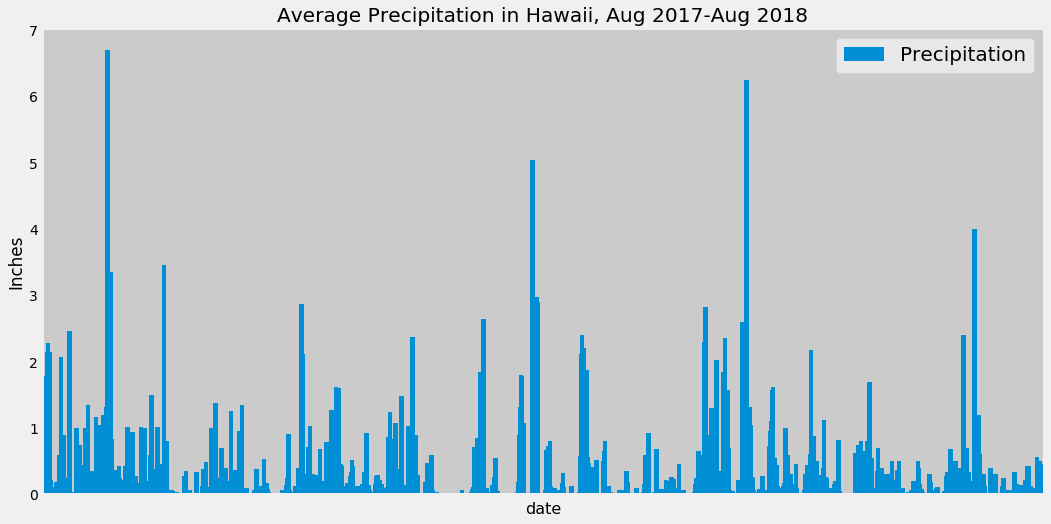

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
ax= prcp_df.plot.bar(figsize=(16,8), width=10)
ax.set_title ("Average Precipitation in Hawaii, Aug 2017-Aug 2018")
ax.set_xlabel("date", fontsize=16)
ax.set_ylabel("Inches")
ax.set_xticklabels([])
plt.legend(['Precipitation'], fontsize=20)
plt.show()

#I don't know how to get the dates to show up without it being crowded
#Getting stumped on saving image

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).group_by(Station.station).count()

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_count = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).all()

station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
#highest temperature recorded, and average temperature of the most active station?

#Most Active Station
most_active_station=session.query(Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).first()
most_active= most_active_station[0]
most_active

'USC00519281'

In [23]:
#Lowest, highest, Average
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station==most_active).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data=session.query(Measurement.tobs).filter(Measurement.station==most_active).\
    filter(Measurement.date>=query_date).all()
temp_data[:25]

[(77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0)]

In [25]:
temp_df = pd.DataFrame(temp_data, columns=["tobs"])
temp_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


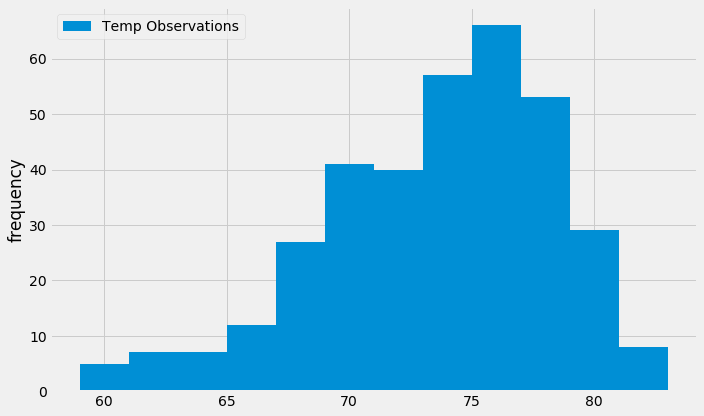

In [26]:
# create the plot
plt.figure(figsize=(10,6))
plt.hist(temp_df["tobs"], bins=12)
plt.ylabel("frequency")
plt.legend(["Temp Observations"])
plt.tight_layout()
plt.show()

# Bonus Challenge Assignment - NOT DOING THE BONUS

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
